<div align='center'>

<a href="https://colab.research.google.com/github/ImagingDataCommons/idc-pathomics-use-case-1/blob/development/src/cptac_use_case.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="center" /> </a>

</div>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ImagingDataCommons/idc-pathomics-use-case-1/blob/development/src/cptac_use_case.ipynb)

# IDC Tutorial: Tissue classification in slide microscopy images

This tutorial demonstrates how to use the Imaging Data Commons (IDC) and Google Cloud Computing (GCP) platforms for pathomics research:

* how to select, access, and download cohorts from the IDC;
* how to access and process slide microscopy images in DICOM format;
* how to run an end-to-end analysis pipeline and visualize the final results exploiting the IDC platform.

Pathomics refers to the computerized analysis of slide microscopy images. Besides radiology, slide microscopy is the second major imaging modality in the IDC. Slide microscopy images show thin sections of tissue samples (e.g., from a resected tumor) at microscopic resolution. They provide a unique glimpse into cellular architecture and function that is essential for diagnosing complex diseases like cancer. Computerized analysis makes the assessment of slide microscopy images more reproducible and less time consuming and it enables the extration of novel digital biomarkers from tissue images.

This tutorial builds on the publication "Classification and mutation prediction from non–small cell lung cancer histopathology images using deep learning" ([Coudray et al. 2018](https://doi.org/10.1038/s41591-018-0177-5)), one of the most cited pathomics publications in recent years. A central use case from this publication is replicated on the CPTAC-LUAD and CPTAC-LSCC data sets in the IDC: the AI-based classification of lung tissue regions into <font color='green'>normal</font>, adenocarcinoma (<font color='red'>LUAD</font>), and squamous cell carcinoma (<font color='blue'>LSCC</font>) tissue. Your own tissue classification use cases can be solved in a similar manner.
  
To be quickly and freely accessible to everyone, this tutorial was deliberately kept simple and designed to be runnable in Google Colab. It highlights only a small part of what the IDC can offer in terms of data exploration and imaging analysis. More complex use cases can be implemented using GCP virtual machines. To learn more about how to access GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


In [1]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

## Prerequisites
This notebook is intended to be run using a **GPU**. A free GPU on Google Colab can be accessed via `Edit > Notebooks Settings`. Then, from the dropdown menu under `Hardware accelerator`, select `GPU`. Colab GPUs mostly include Nvidia K80s, T4s, P4s and P100s. Since there is no way to choose what type of GPU you can connect to, processing times may vary.

In order to execute this notebook in Google Colab and to access IDC resources, you have to:
1. have a **Google identity** (Google authentication is performed below)
2. have already or otherwise newly **configure a project** under Google Cloud Platform (an easy-to-follow description of how to do this can be found [here](https://www.youtube.com/watch?v=i08S0KJLnyw))
3. set **"my_project_id"** below to the ID of the GCP project you have configured under your account

In [4]:
# Ensure that the use of GPU was correctly enabled and check which type of GPU, the Colab instance is equipped with now
gpu_list = !nvidia-smi --list-gpus
has_gpu = False if 'failed' in gpu_list[0] else True
print(has_gpu, gpu_list)

True ['GPU 0: Tesla T4 (UUID: GPU-9c64b1ba-73f1-9ffe-9ee1-d58357017534)']


In [2]:
# Complete the Google Authentication Process by following the the generated link 
from google.colab import auth
auth.authenticate_user()

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# Set my_project_id to the ID of your GCP project
my_project_id = 'idc-pathomics-000'

## Environment setup

The code we implemented for preprocessing the data, for model training and model evaluation is - as well as this notebook - hosted in the open-source Github repository `https://github.com/ImagingDataCommons/IDC-Examples.git`. 
Here, we only need to clone the subdirectory containing our the pathomics use case code, i.e. **`https://https://github.com/ImagingDataCommons/IDC-Examples/tree/master/notebooks`.** The easiest way to do so is to use Apache's subversion `svn` [[Source]](https://en.terminalroot.com.br/how-to-clone-only-a-subdirectory-with-git-or-svn/).

Most python modules and packages preinstalled on a Google Colab instances. Remaining requirements are installed below. 

In [5]:
# Who and where we are:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print('Current directory :', curr_dir[-1])
print('Hostname          :', curr_droid[-1])
print('Username          :', curr_pilot[-1])
!rm -r sample_data # remove /content/sample_data directory which is included in a Google Colab instance by default

Current directory : /home/jupyter/idc-pathomics-use-case-1
Hostname          : idc-patho-vm
Username          : jupyter
rm: cannot remove 'sample_data': No such file or directory


In [ ]:
# Clone the subdirectory containing the code required for this use case
!sudo apt-get update
!sudo apt-get install -y subversion 
#!svn checkout https://github.com/ImagingDataCommons/idc-pathomics-use-case-1/branches/development/src # use trunk instead of branches/branch-name later

In [15]:
# Install openslide for reading and interacting with whole-slide images
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install openslide-wrapper

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-openslide is already the newest version (1.1.1-4).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [6]:
# Import required python modules
import os
import sys
sys.path.append('/usr/local/lib/python3.7/dist-packages') # otherwise Openslide cannot be loaded.
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings 
with warnings.catch_warnings(): # To improve readability, we hide python warnings
    warnings.simplefilter('ignore')

## Dataset selection and exploration

### Dataset selection using BigQuery

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they are available for the user on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `idc-open` bucket.
**Metadata** for the DICOM files - including standard DICOM tags, but also non-DICOM metadata - are stored in BigQuery tables from which they can easily be accessed using standard SQL queries. This gives users the opportunity to explore available data by examining metadata without the need of downloading the DICOM data in the first place. Additional information on the organization of data can be found in the [IDC Documentation](https://learn.canceridc.dev/data/organization-of-data). 

The easiest way to acess BigQuery tables from within a Jupyter notebook is to use the [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) provided by the BigQuery client library for Python. 
Using the `%%bigquery` command as shown below, the results of the following SQL query are stored as pandas data frame `cohort_df`.   
Further information on how to use BigQuery within the IDC, on the attributes available, and code examples can be found [here](https://learn.canceridc.dev/cookbook/bigquery).

In [7]:
# First of all, define and create directories for input and output data 

# in VM
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'

#input_dir = '/content/idc_input/'
#output_dir = '/content/idc_output'
#os.mkdir(input_dir)
#os.mkdir(output_dir)

In [8]:
%%bigquery cohort_df --project=$my_project_id 

WITH slide_images AS (
    SELECT
        ContainerIdentifier AS slide_id,
        PatientID AS patient_id,
        ClinicalTrialProtocolID AS dataset,
        TotalPixelMatrixColumns AS width,
        TotalPixelMatrixRows AS height,
        StudyInstanceUID AS idc_viewer_id,
        gcs_url,
        CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
             PixelMeasuresSequence[OFFSET(0)].
             PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
        CASE TransferSyntaxUID
            WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
            WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
            ELSE 'other'
        END AS compression
    FROM idc-dev-etl.idc_v3.dicom_all
    WHERE NOT (ContainerIdentifier IS NULL)
)
SELECT *
FROM slide_images
WHERE
    (compression = "jpeg")
    AND (dataset = "CPTAC-LUAD" OR dataset = "CPTAC-LSCC")
    -- pixel spacing between 0.00025 and 0.00051 mm corresponds to 20x magnification
    AND (pixel_spacing > 0.00025) AND (pixel_spacing < 0.00051)

Downloading: 100%|██████████| 2211/2211 [00:01<00:00, 1196.60rows/s]


Since up to now the information about the slide's tissue type (tumor tissue or normal tissue) is missing in the BQ table, we have to extract these from the attached TCIA metadata file and add them to our cohort's metadata. We remove slides that have no tissue type information available from our cohort. The final cohort' metadata are saved as *slides_metadata.csv*. 

In [9]:
from src.data.utils import attach_tissue_type_information

tissue_type_data = pd.read_csv('src/tissue_type_data_TCIA.csv')
slides_metadata = attach_tissue_type_information(cohort_df, tissue_type_data)
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_metadata.to_csv(slides_metadata_path, index=False) # Save slides metadata as csv (used later for distribution of slides into train/validation/test set)

### Dataset exploration using python functionality

Using pandas and matplotlib functionality the user can quite easily have a look at the selected cohort's metadata and visualize some aspects of interest: 

In [10]:
display(slides_metadata.head())

print('Total number of slides in this cohort: ', len(slides_metadata))
nr_slides_from_luad_patients = slides_metadata.groupby('cancer_subtype').size()['luad']  
nr_slides_from_lscc_patients = slides_metadata.groupby('cancer_subtype').size()['lscc']
nr_luad_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['luad']
nr_lscc_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['lscc']
print('--> %d slides from %d LUAD patients' %(nr_slides_from_luad_patients, nr_luad_patients))
print('--> %d slides from %d LSCC patients' %(nr_slides_from_lscc_patients, nr_lscc_patients))

,slide_id,patient_id,cancer_subtype,tissue_type,width,height,idc_viewer_id,gcs_url,pixel_spacing,compression
0,C3L-00140-22,C3L-00140,luad,tumor,19919,26744,1.3.6.1.4.1.5962.99.1.2457268337.1666231297.16...,gs://idc_dev/122350a4-700b-4c62-955c-49ce65809...,0.000494,jpeg
1,C3L-00263-21,C3L-00263,luad,tumor,35855,30785,1.3.6.1.4.1.5962.99.1.2436628514.852093794.162...,gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803...,0.000494,jpeg
2,C3L-00279-23,C3L-00279,luad,tumor,21911,20944,1.3.6.1.4.1.5962.99.1.2438645515.2119353088.16...,gs://idc_dev/73aa020b-1990-4b7c-ad4b-295298751...,0.000494,jpeg
3,C3L-00368-26,C3L-00368,luad,normal,17927,17163,1.3.6.1.4.1.5962.99.1.2463949426.1285192452.16...,gs://idc_dev/8eff719c-174a-4efe-9f12-466c91993...,0.000494,jpeg
4,C3L-00444-21,C3L-00444,luad,tumor,101591,46431,1.3.6.1.4.1.5962.99.1.2458615822.286103166.162...,gs://idc_dev/1bc41429-7fb3-4661-b18f-7ef341578...,0.000494,jpeg


Total number of slides in this cohort:  2129
--> 1056 slides from 229 LUAD patients
--> 1073 slides from 211 LSCC patients


Having ~1000 slides from ~200 patients for each cancer subtype, means that there are on average 5 WSI per patient. The left plot of Figure 1 provides more detailed information in form of a histogram. 

**Important:** From every patient (LUAD or LSCC), not only tumor tissue but both tumor tissue and healthy ("normal") tissue samples were collected. The right plot of Figure 1 reveals that in LUAD and LSCC, about one-third of the slides were derived from healthy tissue, while the other two-thirds were derived from cancerous tissue. 

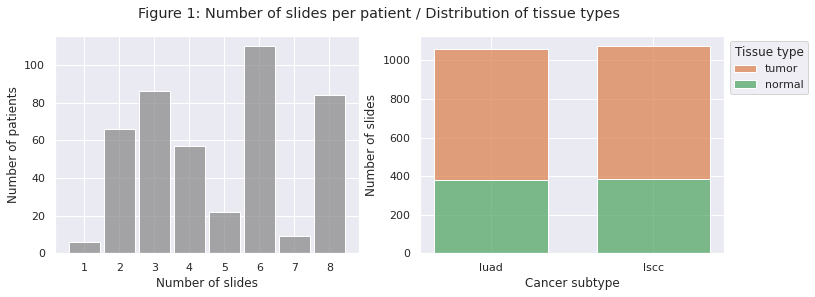

In [11]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig1.suptitle('Figure 1: Number of slides per patient / Distribution of tissue types')

# How many slides per patient? 
slides_per_patient = slides_metadata.groupby(['patient_id', 'cancer_subtype']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color=['C7'])
ax1.set_xlabel('Number of slides')
ax1.set_ylabel('Number of patients')

# How is the relation between slides from healthy / cancerous tissue per cancer subtype?
plot2 = sns.histplot(data=slides_metadata, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C1', 'C2'], ax=ax2, shrink=0.7)
ax2.set_xlabel('Cancer subtype')
ax2.set_ylabel('Number of slides')
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

Any slide can also be easily investigated in detail using the IDC viewer: 

In [12]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

print(get_idc_viewer_url(slides_metadata['idc_viewer_id'][0]))
print(get_idc_viewer_url(slides_metadata['idc_viewer_id'][2000]))

https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2457268337.1666231297.1625954938993.3.0
https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2436806588.1640726514.1625934477244.3.0


## Pathomics experiment 
The following pathomics experiment consists of three main steps: \
&nbsp;&nbsp;&nbsp;&nbsp; `1.` **Preprocessing**: \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `a.` Tiling of slides and filtering out of background tiles \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `b.` Separation into training, validation and test dataset \
&nbsp;&nbsp;&nbsp;&nbsp; `2.` **Training**: Per-tile training of the model \
&nbsp;&nbsp;&nbsp;&nbsp; `3.` **Evaluation**: Per-tile and per-slide evaluation of the trained model

### Preprocessing

**Tile generation**: First, the WSI are downloaded with `gsutil` and the respective "gcs_url"s. Then each slide is tiled into non-overlapping 128x128 pixel windows at a magnification of 5x using the python openslide library. As this code is supposed to serve as a demo requiring a minimum amount of runtime, we reduce each datasets size by generating only one in `twenty` tiles. 

**Generation of datasets**: Next, the tiles are distributed among / sorted into training (70%), test (15%) and validation (15%) datasets, ensuring that tiles associated with a particular patient are not separated, but assigned as a whole to one of these sets. For this purpose, a file (*patient_metadata.csv*) is created that reports the number of tiles created for each patient and is used to generate Figure 3 below. \
Additionally, we update *slides_metadata.csv* by adding the information whether a slide has been assigned to the training, validation or testset. 

In [13]:
from src.data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
#os.mkdir(slides_dir)
#os.mkdir(tiles_dir)

#generate_tiles(slides_dir, slides_metadata_path, tiles_dir, save_every_xth_tile=20, google_cloud_project_id=my_project_id)

In [14]:
from src.data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, output_folder=input_dir)
slides_metadata = pd.read_csv(slides_metadata_path) # reload updated slides_metadata

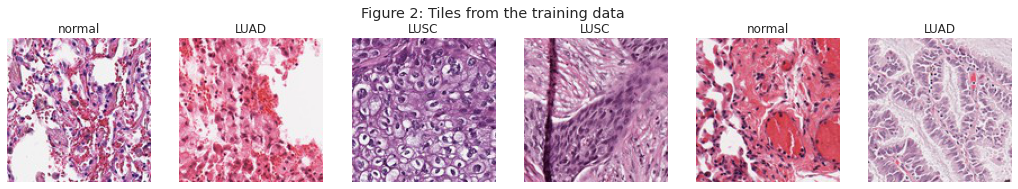

In [17]:
# Visualize some tiles from the training dataset
training_data_list = pd.read_csv(os.path.join(input_dir, 'train_norm_luad_lscc.csv'))
labels = {0:'normal', 1:'LUAD', 2:'LUSC'}
fig2, axes = plt.subplots(1,6, figsize=(18,3))
fig2.suptitle('Figure 2: Tiles from the training data')
for i, idx in enumerate([125000*x for x in range(6)]): 
    axes[i].imshow(plt.imread(os.path.join(input_dir, training_data_list['path'][idx])))
    axes[i].set_title(labels[training_data_list['reference_value'][idx]])
    axes[i].axis('off')

Total number of tiles: 3,592,912


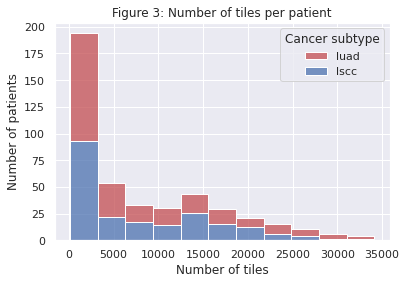

In [18]:
# How many tiles per patient (due to different size of slides)?
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

fig3 = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', palette=['r', 'b'])
fig3.set_title('Figure 3: Number of tiles per patient')
fig3.set_xlabel('Number of tiles')
fig3.set_ylabel('Number of patients')
legend = fig3.get_legend()
legend.set_title('Cancer subtype')

In [29]:
# Only for execution in VM --> remove later!
# Create smaller training / validation and test sets (1/10 of the tiles)
!sed -n '1p;0~40p' "$input_dir/train_norm_luad_lscc.csv" > "$input_dir/train_norm_luad_lscc_40.csv"
!sed -n '1p;0~40p' "$input_dir/valid_norm_luad_lscc.csv" > "$input_dir/valid_norm_luad_lscc_40.csv"
!sed -n '1p;0~40p' "$input_dir/test_norm_luad_lscc.csv" > "$input_dir/test_norm_luad_lscc_40.csv"

### Training

**Network training**: Following Coudray *et al.*, we use the InceptionV3 network architecture as implemented by Keras and shown in the figure below. The loss function is here defined as categorical cross entropy between the true labels and the network's predictions. RMSprop optimizer is utilized for learning with a learning rate of 0.1, weight decay of 0.9, momentum of 0.9 and epsilon of 1.0. Model checkpoints are automatically saved at each epoch in which the validation loss improves. 

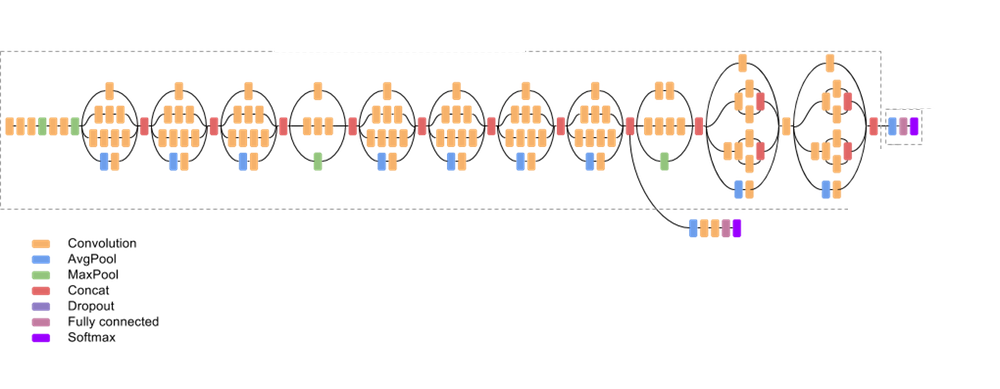

In [ ]:
from src.data.data_set import Dataset
from src.model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

# Load datasets
dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc_40.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc_40.csv'), num_classes=3)

# Model set-up and training
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.1)
model.train(dataset_train, batch_size=512, epochs=10, output_path=output_dir_experiment, validation_dataset=dataset_valid) 

### Evaluation

The final model is selected as the one with the best (minimal) loss on the validation dataset. The performance of this model is evaluated quantitatively by means of receiver operating characteristic (ROC) curves and observed qualitatively using heatmap visualization. First, the model makes predictions for the entire test set and stores them in the experiment's output directory to make subsequent evaluation easily reproducible. 

**ROC analysis** for each of the three classes (normal, LUAD, LSCC) is performed on **tile-level** (tile-based ROC) and on **slide-level** (slide-based ROC). For slide-level analysis the probabilities for each slide were aggregated either by averaging the probabilities of the corresponding tiles, or by counting the percentage of tiles positively classified. Respective Area under the ROC curve (AUC) values are reported in the table below and the slide-based ROC curves are visualized in Figure 4. In addition to the ROC curves for each class, a micro-average ROC was computed and visualized. 

**Heatmaps** for visually inspecting the network's predictions are generated for some of the slides. The color of each tile corresponds to the class assigned by our model, with the hue indicating how confident the network is in this classification whereby a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap. The generation of a thumbnail image takes ~1min, thus we limit ourselves to showing heatmaps for only 4 random slides from the testset. 

In [31]:
# Load the best model 
checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 

#from model.inceptionv3_model import InceptionModel
#from data.data_set import Dataset
#output_dir_experiment='/home/jupyter/idc_output/20210818_161953/'
#best_model_dir = '/home/jupyter/idc_output/20210818_161953/checkpoint_008'

best_model = InceptionModel.load(best_model_dir)

In [32]:
from src.evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc_40.csv'), num_classes=3)
predictions = Predictions(best_model, test_dataset) 
predictions.save(os.path.join(output_dir_experiment, 'predictions_testset_40.json'))

tile-based AUC     slide-based AUC                    
                      average probability percentage positive
Normal          0.887               0.943               0.913
LUAD            0.830               0.863               0.851
LUSC            0.841               0.879               0.866
Micro           0.850               0.893               0.874

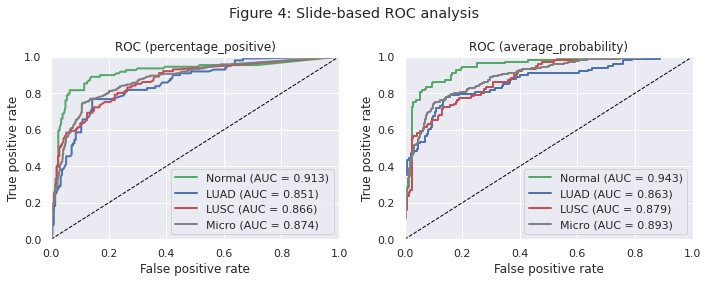

In [33]:
from src.evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions)
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table_40.html'))
roc_analysis.plot_and_save(output_dir_experiment) 

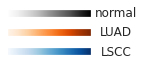

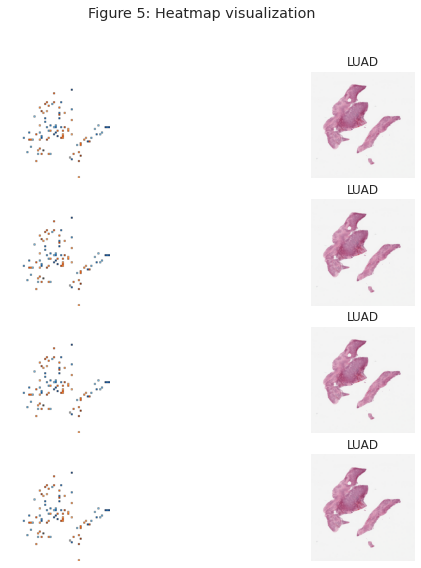

In [37]:
%%capture --no-display
from src.data.utils import get_random_testset_slide_ids, get_thumbnail, get_slide_tissue_type
from src.evaluation.heatmap import get_heatmap, plot_colormap_legend
from src.evaluation.predictions import Predictions

# Select slides and download thumbnails 
heatmap_slide_ids = get_random_testset_slide_ids(slides_metadata)
#get_thumbnail(heatmap_slide_ids, slides_metadata_path, slides_dir, google_cloud_project_id=my_project_id) # NOTE: lasts ~1min per slide

# Generate figure 
plot_colormap_legend()
fig5, axes = plt.subplots(4, 2, figsize=(10, 9))
fig5.suptitle('Figure 5: Heatmap visualization')
for i in range(4):
    slide_id = 'C3L-00913-22'#heatmap_slide_ids[i]
    slide = plt.imread(os.path.join(slides_dir, slide_id + '.png'))
    true_tissue_type = get_slide_tissue_type(slide_id, slides_metadata)
    axes[i,0].imshow(get_heatmap(predictions, slide_id))
    axes[i,1].imshow(slide1)
    axes[i,1].set_title(true_tissue_type.upper())
    axes[i,0].axis('off')
    axes[i,1].axis('off')

## Notes for improvement

### TODOs / Notes for myself 
- **Experienced in Colab that training progress is not printed and it takes quite long..what to do about that, if it appears more often?**
    - AttributeError: 'NoneType' object has no attribute 'shape' --> documented in 03_pitfalls, maybe discuss with Andre
- Check whether we have to change back model(patch_to_predict) to model.predict(patch_to_predict) when using TF/Keras 2.6.0
- Check in general, that everything installed comes with a specific version
- Add a comment about how long tile generation lasts for the user to know beforehand
- Maybe verify successfull installations in notebook to catch errors there? 
- Get that "Open in colab" batch centered
- sys.path.append('/usr/local/lib/python3.7/dist-packages') # otherwise Openslide cannot be loaded. Maybe find a better solution?!
- Remove creation of smaller datasets from large files for everything on Google Colab 
- Heatmap add predicted class --> then we would have to decide on the threshold to use. 
- Adapt stepsize = len(training_data_list) // 10 when visualizing training tiles to make nice onces appear. 
- Remove try-except statement when opening slides --> we expect, that it works for all of them?!

### What to polish
--> Walk through all files to find futher stuff 
- Remove make_single_prediction?
- Remove class_weights parameter completely from the code?
- Check that TCGA-related stuff is removed or generalized e.g. in data_point 
- Make code nicer in roc.py when not showing confidence intervals 

### Final check
- Move to IDC-Examples: adapt svn checkout, Github links in Environment setup text and in Colab Button
- Check that all requirements are installed
- Check that all warnings are suppressed/captured that we want to be captured
- Adapt path to correct idc-Bucket and Slim-viewer
- Check that everything which is only for execution in the VM / development purposes is removed.
- Walk through explanatory text and ensure everything is correct! 
    - Generation of every x-th tile: Check that x is set correctly and matches what stands in the text
    - Adapt text about how many slides there are etc. 
- Make sure, that notebook is saved without output or rather with correct and nice looking output 
- Check if all images (e.g. InceptionV3 or plotted figures) are displayed nicely in Colab

### Other notes: 
- claim GPU only when we are using it, i.e. for training! --> GPU has to be included at the very beginning, other stuff stored is removed otherwise (even Google authentication and variables) 

## To run notebook on VM
- remove Google Colab authentification
- remove GPU activation
- remove Github/svn checkout
- change input/output directory paths 
- Add again creation of smaller datasets from large files (and set save_every_xth_tile=1, if tiles not already downloaded)

## Open questions
- Why do we have so much more tiles than with TCGA data? 

### Answered:
- When will CPTAC data go to official IDC and in which bucket?
    - very soon and into the idc-open bucket